In [80]:
import joblib
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor



In [81]:
evaluation_df =  pd.read_csv("../Data/evaluation_dataset_preprocessed.csv", sep=";")
evaluation_df

,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,datetime,timestamp,FLOW,SPEED_MS_AVG,PORTAL_NUM,PORTAL_GROUP
0,"E4S 55,620",20220101,04:00:00,240,48,16,8,4,2022-01-01 04:00:00,2022-01-01 04:00:00,12.0,21.327500,55620,1
1,"E4S 55,620",20220101,04:01:00,241,48,16,8,4,2022-01-01 04:01:00,2022-01-01 04:01:00,9.0,22.580000,55620,1
2,"E4S 55,620",20220101,04:02:00,242,48,16,8,4,2022-01-01 04:02:00,2022-01-01 04:02:00,7.0,22.375714,55620,1
3,"E4S 55,620",20220101,04:03:00,243,48,16,8,4,2022-01-01 04:03:00,2022-01-01 04:03:00,3.0,22.300000,55620,1
4,"E4S 55,620",20220101,04:04:00,244,48,16,8,4,2022-01-01 04:04:00,2022-01-01 04:04:00,7.0,23.370000,55620,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250265,"E4S 58,140",20220625,09:56:00,596,119,39,19,9,2022-06-25 09:56:00,2022-06-25 09:56:00,22.0,22.123636,58140,4
250266,"E4S 58,140",20220625,09:57:00,597,119,39,19,9,2022-06-25 09:57:00,2022-06-25 09:57:00,13.0,21.793077,58140,4
250267,"E4S 58,140",20220625,09:58:00,598,119,39,19,9,2022-06-25 09:58:00,2022-06-25 09:58:00,27.0,22.252963,58140,4
250268,"E4S 58,140",20220625,09:59:00,599,119,39,19,9,2022-06-25 09:59:00,2022-06-25 09:59:00,18.0,22.191111,58140,4


### Feature Engineering

In [82]:
import pandas as pd

# --- Pre-req: build timestamp and sort ---
evaluation_df = evaluation_df.copy()
evaluation_df["timestamp"] = pd.to_datetime(
    evaluation_df["Date"].astype(str) + " " + evaluation_df["Time"].astype(str),
    format="%Y%m%d %H:%M:%S"
)
evaluation_df = evaluation_df.sort_values(["PORTAL", "timestamp"])

# Optional: quick cadence sanity check (1-minute diffs per portal)
# diffs_ok = (
#     evaluation_df.groupby("PORTAL")["timestamp"]
#     .diff().dropna().dt.total_seconds().mode()
# )
# print("Modal inter-sample spacing (s) per portal:", diffs_ok)

g = evaluation_df.groupby("PORTAL")

# ================= INPUT FEATURES (past-only) =================
# Last 15 minutes aggregates (exclude current minute with shift(1))
evaluation_df["FLOW_AG_15"] = g["FLOW"].transform(lambda s: s.rolling(15, min_periods=15).sum().shift(1))
evaluation_df["SPEED_MS_AVG_AG_15"] = g["SPEED_MS_AVG"].transform(lambda s: s.rolling(15, min_periods=15).mean().shift(1))

# Last 60 minutes flow sum
evaluation_df["FLOW_AG_60"] = g["FLOW"].transform(lambda s: s.rolling(60, min_periods=60).sum().shift(1))

# Same 15-min window yesterday / last week (row-based shifts; 24*60 and 7*24*60 rows)
evaluation_df["FLOW_AG_1d"] = g["FLOW_AG_15"].shift(6 * 60)
evaluation_df["FLOW_AG_1w"] = g["FLOW_AG_15"].shift(7 * 6 * 60)

# ================= TARGET (future 15-min total) =================
# Sum of [t+1, ..., t+15]; align it back to time t with shift(-15)
evaluation_df["FLOW_TARGET_15"] = g["FLOW"].transform(lambda s: s.rolling(15, min_periods=15).sum().shift(-15))

# ================= NA report / drop for modeling =================
key_cols = [
    "FLOW_AG_15",
    "SPEED_MS_AVG_AG_15",
    "FLOW_AG_60",
    "FLOW_AG_1d",
    "FLOW_AG_1w",
    "FLOW_TARGET_15"
]

# --- Workday flag (0 = weekend, 1 = workday) ---
evaluation_df["IS_WORKDAY"] = (evaluation_df["timestamp"].dt.dayofweek < 5).astype("int8")

# --- Hour of day as float (e.g. 7.50 for 07:30) ---
evaluation_df["HOUR_FLOAT"] = (
    evaluation_df["timestamp"].dt.hour +
    evaluation_df["timestamp"].dt.minute / 60.0
).astype("float32")

# Quick checks
print("Workday flag counts:\n", evaluation_df["IS_WORKDAY"].value_counts())
print("Hour range:", evaluation_df["HOUR_FLOAT"].min(), "to", evaluation_df["HOUR_FLOAT"].max())

evaluation_df["DAYOFYEAR"] = evaluation_df["timestamp"].dt.dayofyear

# Cyclical encoding
evaluation_df["DAYOFYEAR_SIN"] = np.sin(2 * np.pi * evaluation_df["DAYOFYEAR"] / 365)
evaluation_df["DAYOFYEAR_COS"] = np.cos(2 * np.pi * evaluation_df["DAYOFYEAR"] / 365)


# Drop rows with NaN in ANY of these columns
features_evaluation_df = evaluation_df.dropna(subset=key_cols)



print("Any NaNs left?", features_evaluation_df[key_cols].isna().any().any())
print("NA counts in key cols:\n", evaluation_df[key_cols].isna().sum())
print("Model df shape:", features_evaluation_df.shape)


Workday flag counts:
 IS_WORKDAY
1    174883
0     75387
Name: count, dtype: int64
Hour range: 4.0 to 10.0
Any NaNs left? False
NA counts in key cols:
 FLOW_AG_15              120
SPEED_MS_AVG_AG_15      120
FLOW_AG_60              480
FLOW_AG_1d             3000
FLOW_AG_1w            20280
FLOW_TARGET_15          120
dtype: int64
Model df shape: (229870, 25)


In [83]:
features_evaluation_df

,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,datetime,timestamp,...,SPEED_MS_AVG_AG_15,FLOW_AG_60,FLOW_AG_1d,FLOW_AG_1w,FLOW_TARGET_15,IS_WORKDAY,HOUR_FLOAT,DAYOFYEAR,DAYOFYEAR_SIN,DAYOFYEAR_COS
2535,"E4S 55,620",20220111,04:12:00,252,50,16,8,4,2022-01-11 04:12:00,2022-01-11 04:12:00,...,20.769761,2301.0,146.0,107.0,167.0,1,4.200000,11,0.188227,0.982126
2536,"E4S 55,620",20220111,04:13:00,253,50,16,8,4,2022-01-11 04:13:00,2022-01-11 04:13:00,...,20.979073,2263.0,129.0,100.0,172.0,1,4.216667,11,0.188227,0.982126
2537,"E4S 55,620",20220111,04:14:00,254,50,16,8,4,2022-01-11 04:14:00,2022-01-11 04:14:00,...,21.055046,2220.0,110.0,98.0,176.0,1,4.233333,11,0.188227,0.982126
2538,"E4S 55,620",20220111,04:15:00,255,51,17,8,4,2022-01-11 04:15:00,2022-01-11 04:15:00,...,21.132380,2185.0,120.0,97.0,178.0,1,4.250000,11,0.188227,0.982126
2539,"E4S 55,620",20220111,04:16:00,256,51,17,8,4,2022-01-11 04:16:00,2022-01-11 04:16:00,...,21.147349,2144.0,123.0,104.0,182.0,1,4.266667,11,0.188227,0.982126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250250,"E4S 58,140",20220625,09:41:00,581,116,38,19,9,2022-06-25 09:41:00,2022-06-25 09:41:00,...,22.236777,897.0,626.0,923.0,291.0,0,9.683333,176,0.111659,-0.993747
250251,"E4S 58,140",20220625,09:42:00,582,116,38,19,9,2022-06-25 09:42:00,2022-06-25 09:42:00,...,21.926701,895.0,635.0,921.0,278.0,0,9.700000,176,0.111659,-0.993747
250252,"E4S 58,140",20220625,09:43:00,583,116,38,19,9,2022-06-25 09:43:00,2022-06-25 09:43:00,...,22.034612,910.0,636.0,928.0,282.0,0,9.716666,176,0.111659,-0.993747
250253,"E4S 58,140",20220625,09:44:00,584,116,38,19,9,2022-06-25 09:44:00,2022-06-25 09:44:00,...,22.147640,917.0,649.0,930.0,278.0,0,9.733334,176,0.111659,-0.993747


In [84]:
# Explicit feature list (without FLOW_AG_60 and PORTAL_NUM)
keep_cols = [
    "timestamp",
    "PORTAL_GROUP",
    "HOUR_FLOAT",
    "IS_WORKDAY",
    "DAYOFYEAR_SIN",
    "DAYOFYEAR_COS",
    "FLOW_AG_15",
    "FLOW_AG_1d",
    "FLOW_AG_1w",
    "SPEED_MS_AVG_AG_15",
    "FLOW_TARGET_15",
]

# Build the new dataframe with only these
no_coll_evaluation_df = features_evaluation_df[keep_cols].copy()

print("New no_coll_training_df shape:", no_coll_evaluation_df.shape)
print("Columns kept:", no_coll_evaluation_df.columns.tolist())

New no_coll_training_df shape: (229870, 11)
Columns kept: ['timestamp', 'PORTAL_GROUP', 'HOUR_FLOAT', 'IS_WORKDAY', 'DAYOFYEAR_SIN', 'DAYOFYEAR_COS', 'FLOW_AG_15', 'FLOW_AG_1d', 'FLOW_AG_1w', 'SPEED_MS_AVG_AG_15', 'FLOW_TARGET_15']


In [85]:
# Later (reload)
best_model_xgb = joblib.load("../Models/xgb_model.pkl")

In [86]:
# 1) Load artifacts
preprocessor = joblib.load("../Models/preprocessor.pkl")

best_model_linreg = joblib.load("../Models/linear_regression_final.pkl")
best_model_xgb = joblib.load("../Models/xgb_model.pkl")
best_model_mlp = joblib.load("../Models/mlp_regressor_final.pkl")


meta         = joblib.load("../Models/meta.pkl")
feature_cols = meta["feature_cols"]

# 2) Build the SAME features on TEST as you did on train (past-only rollings etc.)
#    Make sure columns and order match:
X_test_raw = no_coll_evaluation_df[feature_cols].copy()

# 3) Transform using the TRAIN-FITTED preprocessor (do NOT fit again here)
X_test = preprocessor.transform(X_test_raw)

# 4) Predict
y_pred_linreg = best_model_linreg.predict(X_test)

y_pred_xgb = best_model_xgb.predict(X_test)
y_pred_xgb = np.maximum(0, y_pred_xgb)

y_pred_mlp = best_model_mlp.predict(X_test)


In [87]:
X_test_raw

,FLOW_AG_15,FLOW_AG_1d,FLOW_AG_1w,SPEED_MS_AVG_AG_15,PORTAL_GROUP,HOUR_FLOAT,IS_WORKDAY,DAYOFYEAR_SIN,DAYOFYEAR_COS
2535,237.0,146.0,107.0,20.769761,1,4.200000,1,0.188227,0.982126
2536,196.0,129.0,100.0,20.979073,1,4.216667,1,0.188227,0.982126
2537,169.0,110.0,98.0,21.055046,1,4.233333,1,0.188227,0.982126
2538,131.0,120.0,97.0,21.132380,1,4.250000,1,0.188227,0.982126
2539,134.0,123.0,104.0,21.147349,1,4.266667,1,0.188227,0.982126
...,...,...,...,...,...,...,...,...,...
250250,284.0,626.0,923.0,22.236777,4,9.683333,0,0.111659,-0.993747
250251,285.0,635.0,921.0,21.926701,4,9.700000,0,0.111659,-0.993747
250252,289.0,636.0,928.0,22.034612,4,9.716666,0,0.111659,-0.993747
250253,293.0,649.0,930.0,22.147640,4,9.733334,0,0.111659,-0.993747


In [88]:
y_true = features_evaluation_df["FLOW_TARGET_15"].values

In [89]:
rmse = root_mean_squared_error(y_true, y_pred_linreg)
mae  = mean_absolute_error(y_true, y_pred_linreg)
r2   = r2_score(y_true, y_pred_linreg)
mape = mean_absolute_percentage_error(y_true,y_pred_linreg)

print(f"Test RMSE Linear Regression: {rmse:.2f}")
print(f"Test MAE Linear Regression : {mae:.2f}")
print(f"Test R² Linear Regression   : {r2:.3f}")
print(f"Test MAPE Linear Regression   : {mape:.3f}")


Test RMSE Linear Regression: 142.36
Test MAE Linear Regression : 102.43
Test R² Linear Regression   : 0.801
Test MAPE Linear Regression   : 0.331


In [90]:
rmse = root_mean_squared_error(y_true, y_pred_xgb)
mae  = mean_absolute_error(y_true, y_pred_xgb)
r2   = r2_score(y_true, y_pred_xgb)
mape = mean_absolute_percentage_error(y_true,y_pred_xgb)

print(f"Test RMSE XG Boost: {rmse:.2f}")
print(f"Test MAE XG Boost: {mae:.2f}")
print(f"Test R² XG Boost: {r2:.3f}")
print(f"Test MAPE XG Boost   : {mape:.3f}")


Test RMSE XG Boost: 80.93
Test MAE XG Boost: 57.67
Test R² XG Boost: 0.936
Test MAPE XG Boost   : 0.169


In [91]:
rmse = root_mean_squared_error(y_true, y_pred_mlp)
mae  = mean_absolute_error(y_true, y_pred_mlp)
r2   = r2_score(y_true, y_pred_mlp)
mape = mean_absolute_percentage_error(y_true,y_pred_mlp)

print(f"Test RMSE MLP Boost: {rmse:.2f}")
print(f"Test MAE MLP Boost: {mae:.2f}")
print(f"Test R² MLP Boost: {r2:.3f}")
print(f"Test MAPE MLP Boost   : {mape:.3f}")

Test RMSE MLP Boost: 129.76
Test MAE MLP Boost: 90.94
Test R² MLP Boost: 0.834
Test MAPE MLP Boost   : 0.324


## XG Boost Feature Analysis

In [92]:
# Names after ColumnTransformer (includes transformers' prefixes)
feat_names_out = preprocessor.get_feature_names_out()

clean_names = [name.split("__", 1)[-1] for name in feat_names_out]


In [93]:
importances = best_model_xgb.get_booster().get_score(importance_type='gain')
print(importances)

{'f0': 19263498.0, 'f1': 1150380.5, 'f2': 3032309.5, 'f3': 288719.5625, 'f4': 638571.25, 'f5': 2187754.75, 'f6': 5217037.5, 'f7': 225640.625, 'f8': 475954.4375}


In [94]:
print(feature_cols)

['FLOW_AG_15', 'FLOW_AG_1d', 'FLOW_AG_1w', 'SPEED_MS_AVG_AG_15', 'PORTAL_GROUP', 'HOUR_FLOAT', 'IS_WORKDAY', 'DAYOFYEAR_SIN', 'DAYOFYEAR_COS']


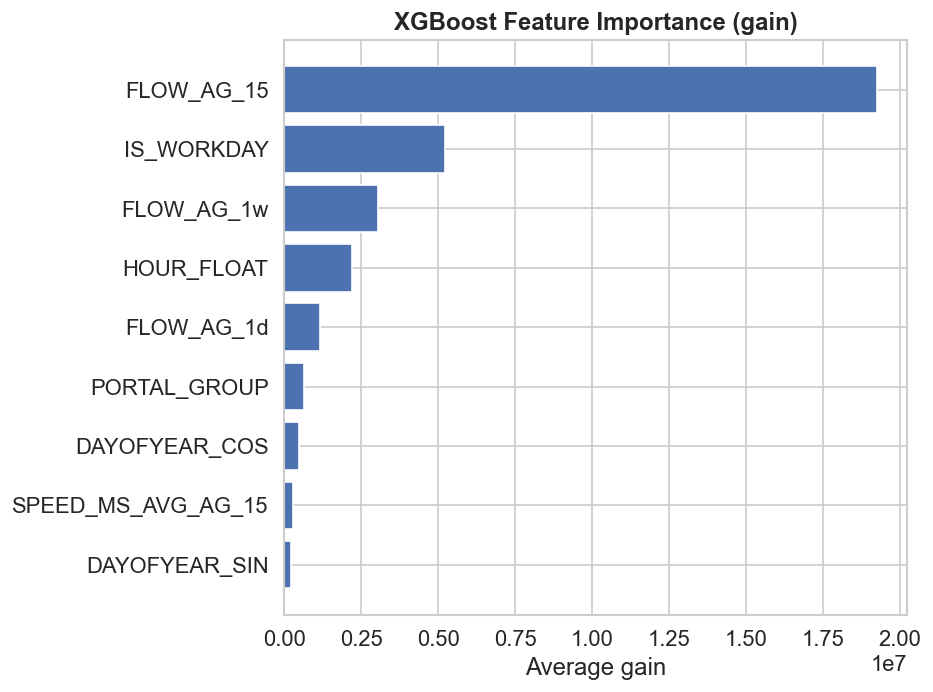

In [95]:
from xgboost import plot_importance

# Raw importance dict keyed as 'f0','f1',...
imp = best_model_xgb.get_booster().get_score(importance_type="gain")

# Map to names
mapped = { clean_names[int(k[1:])]: v for k, v in imp.items() }

# Turn into a sorted list
items = sorted(mapped.items(), key=lambda kv: kv[1], reverse=True)
labels = [k for k, _ in items]
values = [v for _, v in items]

top_k = 20
plt.figure(figsize=(8, 6))
plt.barh(labels[:top_k][::-1], values[:top_k][::-1])
plt.title("XGBoost Feature Importance (gain)")
plt.xlabel("Average gain")
plt.tight_layout()
plt.show()


In [96]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    best_model_xgb,
    X_test,
    y_true,
    n_repeats=5,
    random_state=42,
    scoring="neg_root_mean_squared_error"
)

import pandas as pd
importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

print(importance_df.head(10))


KeyboardInterrupt: 

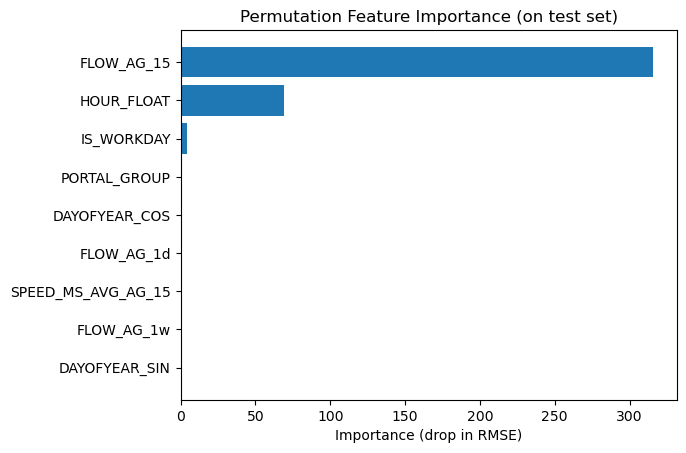

In [34]:
plt.barh(importance_df["feature"], importance_df["importance_mean"])
plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance (on test set)")
plt.xlabel("Importance (drop in RMSE)")
plt.show()


## Scenario Testing

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Helper metric ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


# ===  Evaluate by PORTAL_GROUP ===
portal_metrics = []
for pg, df_pg in features_evaluation_df.groupby("PORTAL_GROUP"):
    X_pg_raw = df_pg[feature_cols]
    X_pg = preprocessor.transform(X_pg_raw)
    y_true_pg = df_pg["FLOW_TARGET_15"].values
    y_pred_pg = best_model_xgb.predict(X_pg)
    
    mae  = mean_absolute_error(y_true_pg, y_pred_pg)
    rmse = np.sqrt(mean_squared_error(y_true_pg, y_pred_pg))
    mape = mean_absolute_percentage_error(y_true_pg, y_pred_pg)
    
    portal_metrics.append({
        "PORTAL_GROUP": pg,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

portal_metrics_df = pd.DataFrame(portal_metrics)
print("Performance by PORTAL_GROUP:")
print(portal_metrics_df.round(3))


# === Evaluate by time-of-day buckets ===
time_ranges = [(4,6), (6,8), (8,10)]
time_metrics = []
for start, end in time_ranges:
    mask = (features_evaluation_df["HOUR_FLOAT"] >= start) & (features_evaluation_df["HOUR_FLOAT"] < end)
    df_time = features_evaluation_df[mask]
    
    if len(df_time) == 0:
        continue  # skip if no data in range
    
    X_t_raw = df_time[feature_cols]
    X_t = preprocessor.transform(X_t_raw)
    y_true_t = df_time["FLOW_TARGET_15"].values
    y_pred_t = best_model_xgb.predict(X_t)
    
    mae  = mean_absolute_error(y_true_t, y_pred_t)
    rmse = np.sqrt(mean_squared_error(y_true_t, y_pred_t))
    mape = mean_absolute_percentage_error(y_true_t, y_pred_t)
    
    time_metrics.append({
        "TimeRange": f"{start:02d}-{end:02d}",
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

time_metrics_df = pd.DataFrame(time_metrics)
print("\nPerformance by Time Range:")



Performance by PORTAL_GROUP:
   PORTAL_GROUP     MAE    RMSE    MAPE
0             1  56.350  77.283  14.519
1             2  60.215  81.684  15.779
2             3  61.452  88.105  17.880
3             4  55.425  77.704  17.322

Performance by Time Range:


In [98]:
portal_metrics_df.round(3)

,PORTAL_GROUP,MAE,RMSE,MAPE
0,1,56.350,77.283,14.519
1,2,60.215,81.684,15.779
2,3,61.452,88.105,17.880
3,4,55.425,77.704,17.322


In [99]:
time_metrics_df.round(3)

,TimeRange,MAE,RMSE,MAPE
0,04-06,46.208,69.722,22.184
1,06-08,61.983,81.396,13.884
2,08-10,64.174,89.268,13.793


In [100]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Helper metric (same as before) ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Ensure sorted
dfm = features_evaluation_df.sort_values("timestamp").copy()

# Add YYYY-MM key
dfm["YYYY_MM"] = dfm["timestamp"].dt.to_period("M").astype(str)

# Compute metrics per month
monthly_rows = []
for month, df_sub in dfm.groupby("YYYY_MM", sort=True):
    if df_sub.empty:
        continue
    X_sub_raw = df_sub[feature_cols]
    X_sub = preprocessor.transform(X_sub_raw)
    y_true_sub = df_sub["FLOW_TARGET_15"].values
    y_pred_sub = best_model_xgb.predict(X_sub)

    mae  = mean_absolute_error(y_true_sub, y_pred_sub)
    rmse = np.sqrt(mean_squared_error(y_true_sub, y_pred_sub))
    mape = mean_absolute_percentage_error(y_true_sub, y_pred_sub)

    monthly_rows.append({
        "Month": month,
        "Start": df_sub["timestamp"].min(),
        "End":   df_sub["timestamp"].max(),
        "Rows":  len(df_sub),
        "MAE":   mae,
        "RMSE":  rmse,
        "MAPE":  mape
    })

monthly_metrics_df = pd.DataFrame(monthly_rows).sort_values("Month").reset_index(drop=True)

print("\nPerformance by Month:")
print(monthly_metrics_df.round({
    "MAE": 3, "RMSE": 3, "MAPE": 3
}))



Performance by Month:
     Month               Start                 End   Rows     MAE    RMSE  \
0  2022-01 2022-01-11 04:09:00 2022-01-31 10:00:00  34280  53.901  67.476   
1  2022-02 2022-02-03 04:00:00 2022-02-28 10:00:00  31661  50.849  69.526   
2  2022-03 2022-03-03 04:00:00 2022-03-30 10:00:00  48940  62.289  91.524   
3  2022-04 2022-04-02 04:00:00 2022-04-30 10:00:00  40047  54.538  78.107   
4  2022-05 2022-05-02 04:00:00 2022-05-29 10:00:00  44760  57.213  80.447   
5  2022-06 2022-06-02 04:00:00 2022-06-25 09:45:00  30182  66.727  91.745   

     MAPE  
0  24.999  
1  16.932  
2  18.730  
3  14.423  
4  11.566  
5  16.042  


/var/folders/ww/hnj0z7l577b2_jzdg6515pfm0000gn/T/ipykernel_57667/2603553572.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


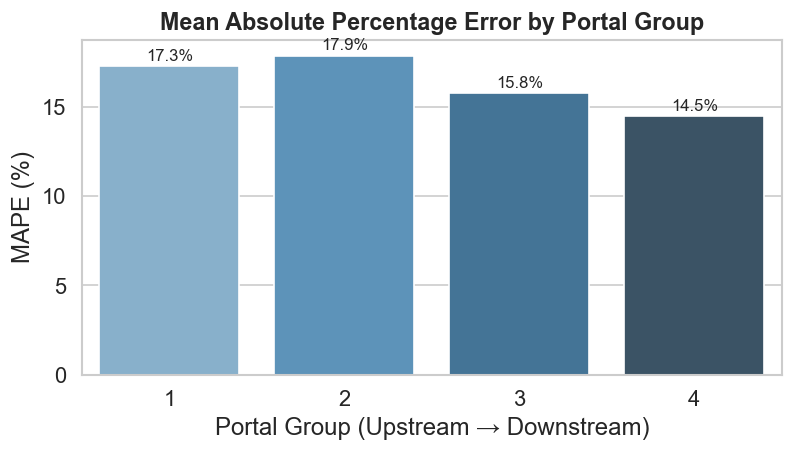

/var/folders/ww/hnj0z7l577b2_jzdg6515pfm0000gn/T/ipykernel_57667/2603553572.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


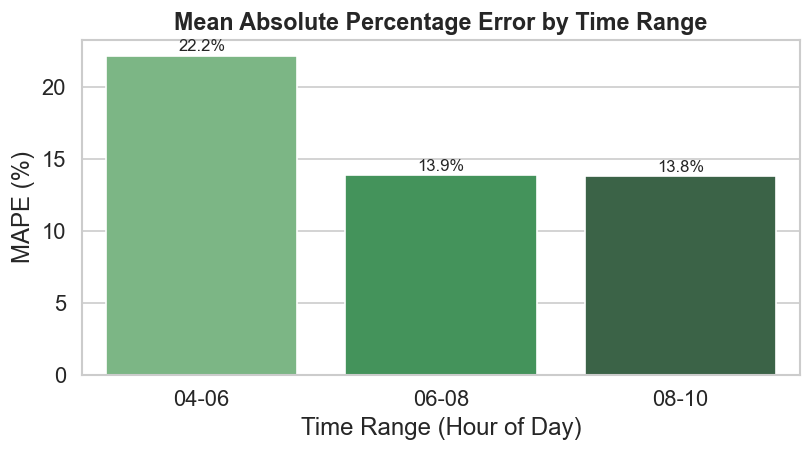

/var/folders/ww/hnj0z7l577b2_jzdg6515pfm0000gn/T/ipykernel_57667/2603553572.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


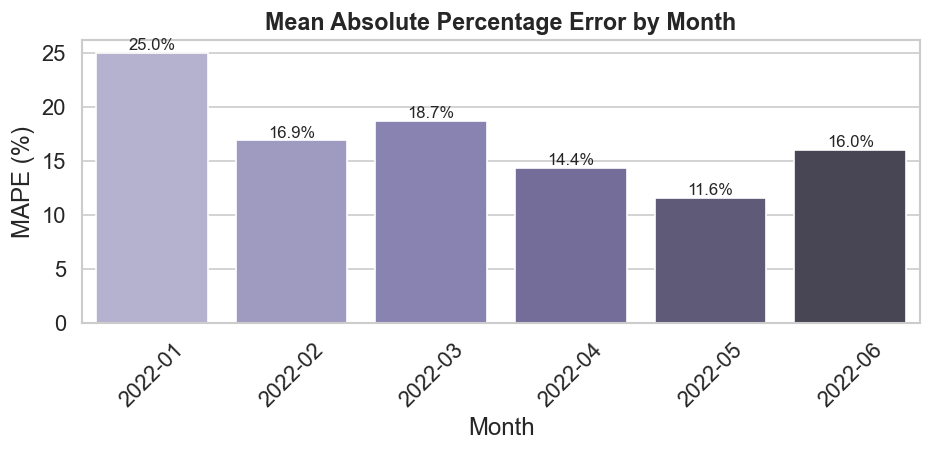

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

# Reverse mapping, e.g. 1<->4, 2<->3
reversed_labels = {1:4, 2:3, 3:2, 4:1}
portal_metrics_df["PORTAL_GROUP_LABEL"] = portal_metrics_df["PORTAL_GROUP"].map(reversed_labels)

plt.figure(figsize=(7,4))
sns.barplot(
    data=portal_metrics_df.sort_values("PORTAL_GROUP_LABEL"),
    x="PORTAL_GROUP_LABEL", y="MAPE", palette="Blues_d"
)
plt.title("Mean Absolute Percentage Error by Portal Group", fontsize=14, weight="bold")
plt.xlabel("Portal Group (Upstream → Downstream)")
plt.ylabel("MAPE (%)")

for i, v in enumerate(portal_metrics_df.sort_values("PORTAL_GROUP_LABEL")["MAPE"].round(1)):
    plt.text(i, v + 0.3, f"{v:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


# === MAPE by Time Range ===
plt.figure(figsize=(7,4))
sns.barplot(
    data=time_metrics_df,
    x="TimeRange", y="MAPE", palette="Greens_d"
)
plt.title("Mean Absolute Percentage Error by Time Range", fontsize=14, weight="bold")
plt.xlabel("Time Range (Hour of Day)")
plt.ylabel("MAPE (%)")
for i, v in enumerate(time_metrics_df["MAPE"].round(1)):
    plt.text(i, v + 0.3, f"{v:.1f}%", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# === MAPE by Month (optional if you computed monthly_metrics_df) ===
if 'monthly_metrics_df' in globals():
    plt.figure(figsize=(8,4))
    sns.barplot(
        data=monthly_metrics_df,
        x="Month", y="MAPE", palette="Purples_d"
    )
    plt.title("Mean Absolute Percentage Error by Month", fontsize=14, weight="bold")
    plt.xlabel("Month")
    plt.ylabel("MAPE (%)")
    plt.xticks(rotation=45)
    for i, v in enumerate(monthly_metrics_df["MAPE"].round(1)):
        plt.text(i, v + 0.3, f"{v:.1f}%", ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()



In [102]:
features_evaluation_df

,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,datetime,timestamp,...,SPEED_MS_AVG_AG_15,FLOW_AG_60,FLOW_AG_1d,FLOW_AG_1w,FLOW_TARGET_15,IS_WORKDAY,HOUR_FLOAT,DAYOFYEAR,DAYOFYEAR_SIN,DAYOFYEAR_COS
2535,"E4S 55,620",20220111,04:12:00,252,50,16,8,4,2022-01-11 04:12:00,2022-01-11 04:12:00,...,20.769761,2301.0,146.0,107.0,167.0,1,4.200000,11,0.188227,0.982126
2536,"E4S 55,620",20220111,04:13:00,253,50,16,8,4,2022-01-11 04:13:00,2022-01-11 04:13:00,...,20.979073,2263.0,129.0,100.0,172.0,1,4.216667,11,0.188227,0.982126
2537,"E4S 55,620",20220111,04:14:00,254,50,16,8,4,2022-01-11 04:14:00,2022-01-11 04:14:00,...,21.055046,2220.0,110.0,98.0,176.0,1,4.233333,11,0.188227,0.982126
2538,"E4S 55,620",20220111,04:15:00,255,51,17,8,4,2022-01-11 04:15:00,2022-01-11 04:15:00,...,21.132380,2185.0,120.0,97.0,178.0,1,4.250000,11,0.188227,0.982126
2539,"E4S 55,620",20220111,04:16:00,256,51,17,8,4,2022-01-11 04:16:00,2022-01-11 04:16:00,...,21.147349,2144.0,123.0,104.0,182.0,1,4.266667,11,0.188227,0.982126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250250,"E4S 58,140",20220625,09:41:00,581,116,38,19,9,2022-06-25 09:41:00,2022-06-25 09:41:00,...,22.236777,897.0,626.0,923.0,291.0,0,9.683333,176,0.111659,-0.993747
250251,"E4S 58,140",20220625,09:42:00,582,116,38,19,9,2022-06-25 09:42:00,2022-06-25 09:42:00,...,21.926701,895.0,635.0,921.0,278.0,0,9.700000,176,0.111659,-0.993747
250252,"E4S 58,140",20220625,09:43:00,583,116,38,19,9,2022-06-25 09:43:00,2022-06-25 09:43:00,...,22.034612,910.0,636.0,928.0,282.0,0,9.716666,176,0.111659,-0.993747
250253,"E4S 58,140",20220625,09:44:00,584,116,38,19,9,2022-06-25 09:44:00,2022-06-25 09:44:00,...,22.147640,917.0,649.0,930.0,278.0,0,9.733334,176,0.111659,-0.993747


In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Helper metric (same as before) ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def make_quantile_bins(series: pd.Series, q: int = 4):
    """
    Build robust quantile bins:
    - compute quantile edges,
    - drop duplicate edges,
    - return a labeled categorical Series (Q1..Qk) + a mapping table.
    Handles empty/constant-series cases.
    """
    s = series.dropna()

    # Case 1: no data after dropping NaNs
    if s.empty:
        seg = pd.Series(pd.Categorical(["All"] * len(series)), index=series.index)
        mapping = pd.DataFrame([{"Label": "All", "Range": "[empty]"}])
        return seg, mapping

    # Case 2: all values identical (or effectively 1 unique)
    if s.nunique() < 2:
        v = s.iloc[0]
        seg = pd.Series(pd.Categorical(["All"] * len(series)), index=series.index)
        mapping = pd.DataFrame([{"Label": "All", "Range": f"[{v}, {v}]"}])
        return seg, mapping

    # Case 3: proper quantile binning
    edges = np.quantile(s, q=np.linspace(0, 1, q + 1))
    edges = np.unique(edges)  # remove duplicates (flat regions)
    if len(edges) < 2:
        # fallback if after uniqueness we lost bins
        v = s.iloc[0]
        seg = pd.Series(pd.Categorical(["All"] * len(series)), index=series.index)
        mapping = pd.DataFrame([{"Label": "All", "Range": f"[{v}, {v}]"}])
        return seg, mapping

    # Create intervals on the original series index 
    intervals = pd.cut(series, bins=edges, include_lowest=True)
    labels = [f"Q{i+1}" for i in range(len(edges) - 1)]
    seg = intervals.cat.rename_categories(labels)

    mapping = pd.DataFrame({
        "Label": labels,
        "Range": [str(iv) for iv in intervals.cat.categories]
    })
    return seg, mapping

def evaluate_by_segment(df: pd.DataFrame, segment_col: str):
    """Compute MAE/RMSE/MAPE per segment label (like your monthly loop)."""
    rows = []
    for seg, df_sub in df.groupby(segment_col, sort=True):
        if df_sub.empty:
            continue
        X_sub = preprocessor.transform(df_sub[feature_cols])
        y_true_sub = df_sub["FLOW_TARGET_15"].values
        y_pred_sub = best_model_xgb.predict(X_sub)

        mae  = mean_absolute_error(y_true_sub, y_pred_sub)
        rmse = np.sqrt(mean_squared_error(y_true_sub, y_pred_sub))
        mape = mean_absolute_percentage_error(y_true_sub, y_pred_sub)

        rows.append({
            "Segment": seg,
            "Rows": len(df_sub),
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape
        })
    return pd.DataFrame(rows).sort_values("Segment").reset_index(drop=True)

# ===== A) Segment by INPUT FLOW (FLOW_AG_15) =====


df_flow = features_evaluation_df.sort_values("timestamp").copy()

print("Features", features_evaluation_df)

df_flow["FLOW_SEG"], flow_mapping = make_quantile_bins(df_flow["FLOW_AG_15"], q=4)

flow_metrics_df = evaluate_by_segment(df_flow, "FLOW_SEG")


print("\nFLOW_AG_15 quantile bins:")
print(flow_mapping)
print("\nPerformance by Input Flow Segment (FLOW_AG_15):")
print(flow_metrics_df.round({"MAE":3, "RMSE":3, "MAPE":3}))

# ===== B) Segment by INPUT SPEED (SPEED_MS_AVG_AG_15) =====
df_speed = features_evaluation_df.sort_values("timestamp").copy()
df_speed["SPEED_SEG"], speed_mapping = make_quantile_bins(df_speed["SPEED_MS_AVG_AG_15"], q=4)
speed_metrics_df = evaluate_by_segment(df_speed, "SPEED_SEG")

print("\nSPEED_MS_AVG_AG_15 quantile bins:")
print(speed_mapping)
print("\nPerformance by Input Speed Segment (SPEED_MS_AVG_AG_15):")
print(speed_metrics_df.round({"MAE":3, "RMSE":3, "MAPE":3}))


Features             PORTAL      Date      Time  Interval_1  Interval_5  Interval_15  \
2535    E4S 55,620  20220111  04:12:00         252          50           16   
2536    E4S 55,620  20220111  04:13:00         253          50           16   
2537    E4S 55,620  20220111  04:14:00         254          50           16   
2538    E4S 55,620  20220111  04:15:00         255          51           17   
2539    E4S 55,620  20220111  04:16:00         256          51           17   
...            ...       ...       ...         ...         ...          ...   
250250  E4S 58,140  20220625  09:41:00         581         116           38   
250251  E4S 58,140  20220625  09:42:00         582         116           38   
250252  E4S 58,140  20220625  09:43:00         583         116           38   
250253  E4S 58,140  20220625  09:44:00         584         116           38   
250254  E4S 58,140  20220625  09:45:00         585         117           39   

        Interval_30  Interval_60          

/var/folders/ww/hnj0z7l577b2_jzdg6515pfm0000gn/T/ipykernel_57667/3987513371.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, df_sub in df.groupby(segment_col, sort=True):



FLOW_AG_15 quantile bins:
  Label            Range
0    Q1  (17.999, 272.0]
1    Q2   (272.0, 701.0]
2    Q3   (701.0, 870.0]
3    Q4  (870.0, 1253.0]

Performance by Input Flow Segment (FLOW_AG_15):
  Segment   Rows     MAE    RMSE    MAPE
0      Q1  57469  37.149  48.615  29.884
1      Q2  57583  69.935  96.420  19.372
2      Q3  57734  65.315  88.503  12.725
3      Q4  57084  76.575  97.080   9.972

SPEED_MS_AVG_AG_15 quantile bins:
  Label             Range
0    Q1   (3.029, 19.204]
1    Q2  (19.204, 20.271]
2    Q3  (20.271, 21.222]
3    Q4  (21.222, 24.586]

Performance by Input Speed Segment (SPEED_MS_AVG_AG_15):
  Segment   Rows     MAE    RMSE    MAPE
0      Q1  57468  69.646  96.415  16.739
1      Q2  57467  62.539  83.684  16.840
2      Q3  57467  58.127  78.733  18.819
3      Q4  57468  58.596  80.075  19.587


/var/folders/ww/hnj0z7l577b2_jzdg6515pfm0000gn/T/ipykernel_57667/3987513371.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, df_sub in df.groupby(segment_col, sort=True):


/var/folders/ww/hnj0z7l577b2_jzdg6515pfm0000gn/T/ipykernel_57667/2490684793.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


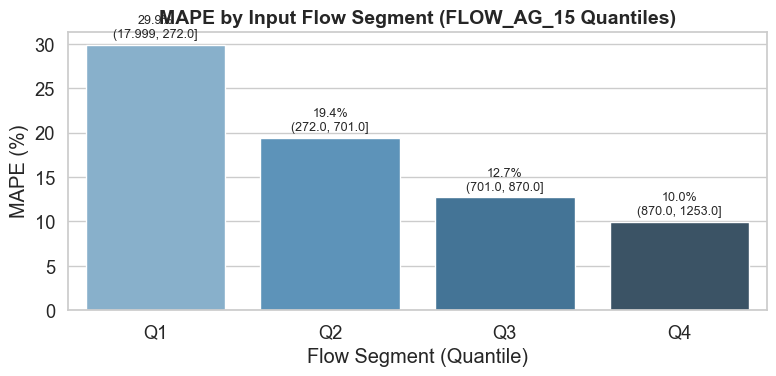

/var/folders/ww/hnj0z7l577b2_jzdg6515pfm0000gn/T/ipykernel_57667/2490684793.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


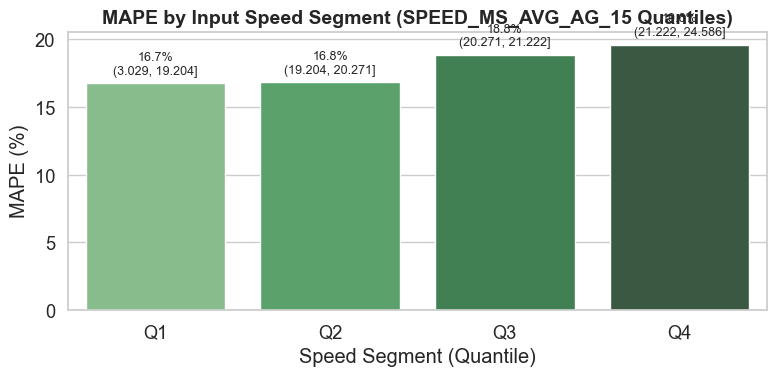

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

# --- Merge value ranges into metrics ---
flow_metrics_df = flow_metrics_df.merge(flow_mapping, left_on="Segment", right_on="Label", how="left")
speed_metrics_df = speed_metrics_df.merge(speed_mapping, left_on="Segment", right_on="Label", how="left")

# Sort by Segment label order (Q1..Q4 etc.)
flow_metrics_df["Segment"] = pd.Categorical(flow_metrics_df["Segment"], categories=flow_mapping["Label"], ordered=True)
speed_metrics_df["Segment"] = pd.Categorical(speed_metrics_df["Segment"], categories=speed_mapping["Label"], ordered=True)

# ===== MAPE by Input Flow Segment =====
plt.figure(figsize=(8,4))
sns.barplot(
    data=flow_metrics_df,
    x="Segment", y="MAPE", palette="Blues_d"
)
plt.title("MAPE by Input Flow Segment (FLOW_AG_15 Quantiles)", fontsize=14, weight="bold")
plt.xlabel("Flow Segment (Quantile)")
plt.ylabel("MAPE (%)")

# Annotate both MAPE and range
for i, (v, rng) in enumerate(zip(flow_metrics_df["MAPE"].round(1), flow_metrics_df["Range"])):
    plt.text(i, v + 0.5, f"{v:.1f}%\n{rng}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# ===== MAPE by Input Speed Segment =====
plt.figure(figsize=(8,4))
sns.barplot(
    data=speed_metrics_df,
    x="Segment", y="MAPE", palette="Greens_d"
)
plt.title("MAPE by Input Speed Segment (SPEED_MS_AVG_AG_15 Quantiles)", fontsize=14, weight="bold")
plt.xlabel("Speed Segment (Quantile)")
plt.ylabel("MAPE (%)")

# Annotate both MAPE and range
for i, (v, rng) in enumerate(zip(speed_metrics_df["MAPE"].round(1), speed_metrics_df["Range"])):
    plt.text(i, v + 0.5, f"{v:.1f}%\n{rng}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [103]:
features_eval = features_evaluation_df.copy()
features_eval["y_true"] = y_true
features_eval["y_pred"] = y_pred_xgb  # or any model
features_eval["residual"] = features_eval["y_true"] - features_eval["y_pred"]
features_eval["abs_residual"] = np.abs(features_eval["residual"])


# Example: by hour of day
hour_summary = (
    features_eval.groupby(features_eval["timestamp"].dt.hour)["abs_residual"]
    .mean()
    .reset_index(name="MeanAbsResidual")
)

# Example: by portal group
portal_summary = (
    features_eval.groupby("PORTAL_GROUP")["abs_residual"]
    .mean()
    .reset_index(name="MeanAbsResidual")
)

# Example: by speed deciles
speed_bins = pd.qcut(features_eval["SPEED_MS_AVG_AG_15"], q=10, duplicates="drop")
speed_summary = (
    features_eval.groupby(speed_bins)["abs_residual"]
    .mean()
    .reset_index()
)


/var/folders/ww/hnj0z7l577b2_jzdg6515pfm0000gn/T/ipykernel_57667/1414519308.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  features_eval.groupby(speed_bins)["abs_residual"]


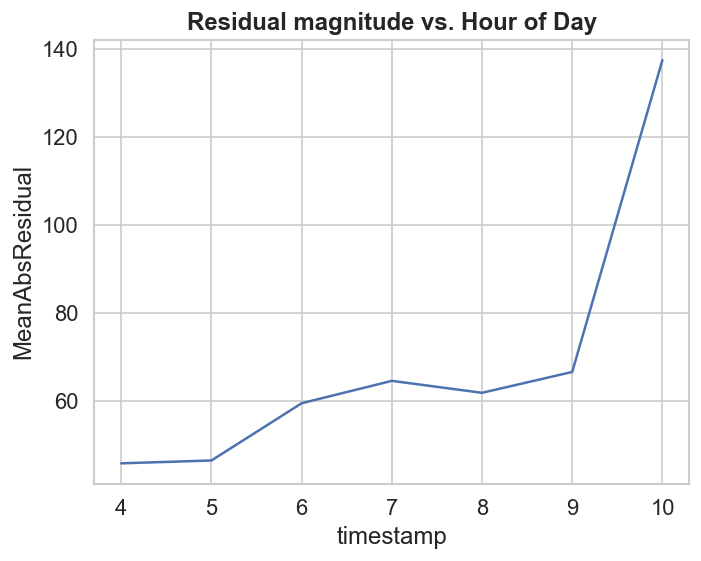

In [104]:
sns.lineplot(data=hour_summary, x="timestamp", y="MeanAbsResidual")
plt.title("Residual magnitude vs. Hour of Day")
plt.show()


In [105]:
corrs = (
    features_eval[feature_cols + ["residual"]]
    .corr()["residual"]
    .drop("residual")
    .sort_values(ascending=False)
)
print("Correlation of residuals with features:")
print(corrs)


Correlation of residuals with features:
FLOW_AG_15            0.265751
IS_WORKDAY            0.162398
PORTAL_GROUP          0.066441
FLOW_AG_1d            0.030363
DAYOFYEAR_SIN         0.012158
HOUR_FLOAT           -0.080235
FLOW_AG_1w           -0.092375
SPEED_MS_AVG_AG_15   -0.164269
DAYOFYEAR_COS        -0.165589
Name: residual, dtype: float64


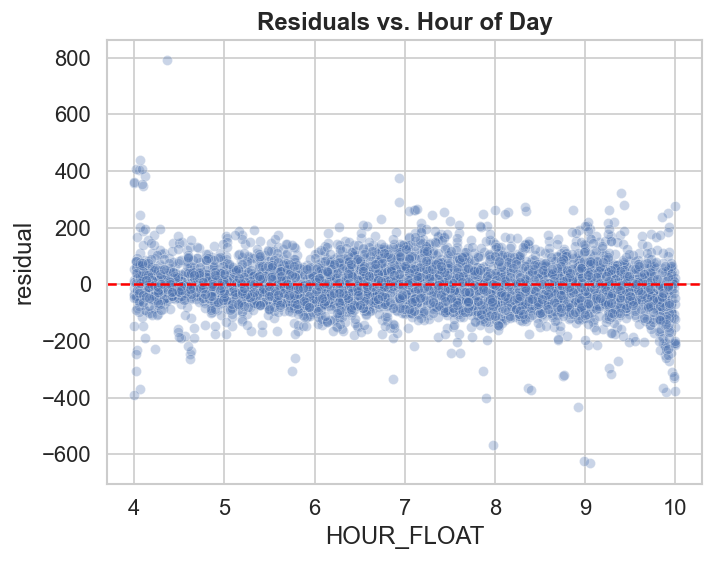

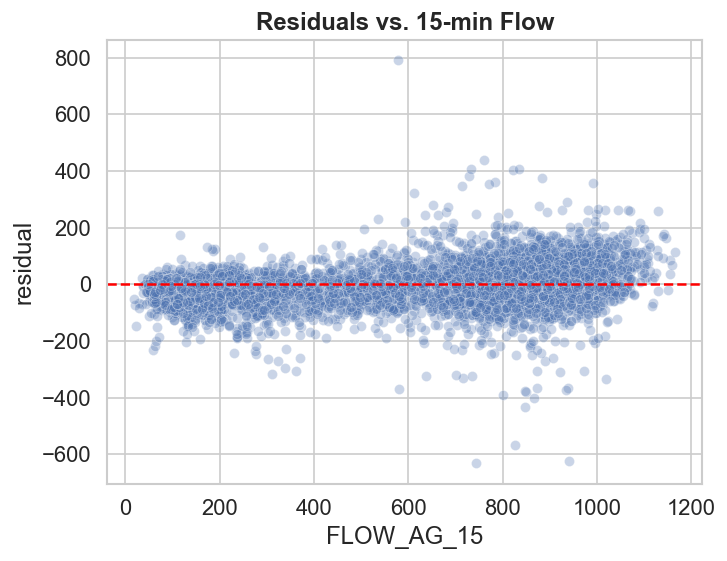

In [106]:
sns.scatterplot(
    data=features_eval.sample(5000, random_state=0),
    x="HOUR_FLOAT", y="residual", alpha=0.3
)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs. Hour of Day")
plt.show()

sns.scatterplot(
    data=features_eval.sample(5000, random_state=0),
    x="FLOW_AG_15", y="residual", alpha=0.3
)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs. 15-min Flow")
plt.show()


In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------- Styling (nice for PPT) ----------
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "axes.titleweight": "bold",
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "legend.frameon": False,
})

def _metrics_text(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return f"RMSE={rmse:.2f}  |  MAE={mae:.2f}  |  R²={r2:.3f}"

# ---------- 1) Parity scatter ----------
def plot_parity_scatter(y_true, y_pred, title="Predicted vs. Actual", fname="parity_scatter.png"):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    lo = np.nanmin([y_true, y_pred]); hi = np.nanmax([y_true, y_pred])
    pad = 0.02 * (hi - lo if hi > lo else 1)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, s=10, alpha=0.35, ax=ax)
    ax.plot([lo - pad, hi + pad], [lo - pad, hi + pad], ls="--", lw=2, color="black", alpha=0.7)
    ax.set_xlabel("Actual (y)")
    ax.set_ylabel("Predicted (ŷ)")
    ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")
    ax.text(0.02, 0.98, _metrics_text(y_true, y_pred), transform=ax.transAxes,
            va="top", ha="left", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.8", alpha=0.9))
    sns.despine()
    plt.tight_layout()
    plt.savefig(fname, bbox_inches="tight")
    plt.show()

# ---------- 2) Parity hexbin (for large n) ----------
def plot_parity_hexbin(y_true, y_pred, gridsize=40, title="Predicted vs. Actual (Hexbin)", fname="parity_hexbin.png"):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    lo = np.nanmin([y_true, y_pred]); hi = np.nanmax([y_true, y_pred])
    pad = 0.02 * (hi - lo if hi > lo else 1)

    fig, ax = plt.subplots(figsize=(8, 6))
    hb = ax.hexbin(y_true, y_pred, gridsize=gridsize, cmap="viridis", mincnt=1)
    ax.plot([lo - pad, hi + pad], [lo - pad, hi + pad], ls="--", lw=2, color="white", alpha=0.9)
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label("Count")
    ax.set_xlabel("Actual (y)")
    ax.set_ylabel("Predicted (ŷ)")
    ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")
    ax.text(0.02, 0.98, _metrics_text(y_true, y_pred), transform=ax.transAxes,
            va="top", ha="left", color="white",
            bbox=dict(boxstyle="round,pad=0.3", fc="black", ec="0.2", alpha=0.5))
    sns.despine()
    plt.tight_layout()
    plt.savefig(fname, bbox_inches="tight")
    plt.show()

# ---------- 3) Residuals vs. Predicted ----------
def plot_residuals_vs_pred(y_true, y_pred, title="Residuals vs. Predicted", fname="residuals_vs_pred.png"):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    resid = y_true - y_pred

    fig, ax = plt.subplots(figsize=(8, 5.5))
    sns.scatterplot(x=y_pred, y=resid, s=10, alpha=0.35, ax=ax)
    ax.axhline(0, color="black", lw=2, ls="--", alpha=0.7)
    ax.set_xlabel("Predicted (ŷ)")
    ax.set_ylabel("Residual (y − ŷ)")
    ax.set_title(title)
    ax.text(0.02, 0.98, _metrics_text(y_true, y_pred), transform=ax.transAxes,
            va="top", ha="left", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.8", alpha=0.9))
    sns.despine()
    plt.tight_layout()
    plt.savefig(fname, bbox_inches="tight")
    plt.show()

# ---------- 4) Residual distribution ----------
def plot_residual_dist(y_true, y_pred, bins=40, title="Residual Distribution", fname="residual_dist.png"):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    resid = y_true - y_pred

    fig, ax = plt.subplots(figsize=(8, 5.5))
    sns.histplot(resid, bins=bins, kde=True, ax=ax)
    ax.axvline(0, color="black", lw=2, ls="--", alpha=0.7)
    ax.set_xlabel("Residual (y − ŷ)")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.text(0.02, 0.98, _metrics_text(y_true, y_pred), transform=ax.transAxes,
            va="top", ha="left", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.8", alpha=0.9))
    sns.despine()
    plt.tight_layout()
    plt.savefig(fname, bbox_inches="tight")
    plt.show()

# ---------- 5) Error by true-value deciles ----------
def plot_error_by_true_decile(y_true, y_pred, q=10, which=("MAPE","MAE","RMSE"),
                              title="Error by True-Value Decile", fname="error_by_decile.png"):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    df = pd.DataFrame({"y": y_true, "yhat": y_pred}).dropna()
    # build deciles of actual y
    df["Decile"] = pd.qcut(df["y"], q=q, labels=[f"Q{i+1}" for i in range(q)], duplicates="drop")
    # metrics
    def mape(a, b):
        mask = a != 0
        return np.mean(np.abs((a[mask]-b[mask]) / a[mask])) * 100 if mask.any() else np.nan
    agg = df.groupby("Decile").apply(
        lambda d: pd.Series({
            "MAPE": mape(d["y"].values, d["yhat"].values),
            "MAE" : mean_absolute_error(d["y"], d["yhat"]),
            "RMSE": np.sqrt(mean_squared_error(d["y"], d["yhat"]))
        })
    ).reset_index()

    use_cols = [c for c in which if c in agg.columns]
    agg_m = agg.melt(id_vars="Decile", value_vars=use_cols, var_name="Metric", value_name="Value")

    fig, ax = plt.subplots(figsize=(10, 5.5))
    sns.barplot(data=agg_m, x="Decile", y="Value", hue="Metric", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("True-value decile")
    ax.set_ylabel("Error")
    ax.legend(title="")
    sns.despine()
    plt.tight_layout()
    plt.savefig(fname, bbox_inches="tight")
    plt.show()


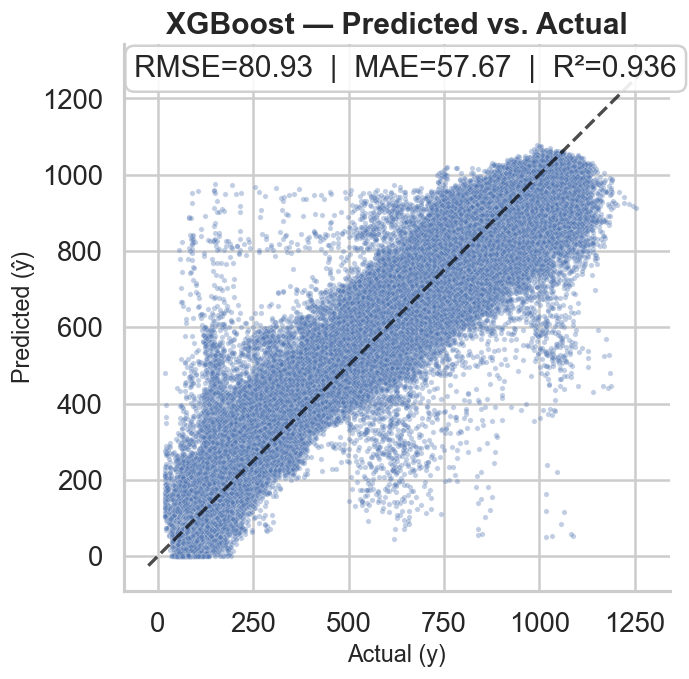

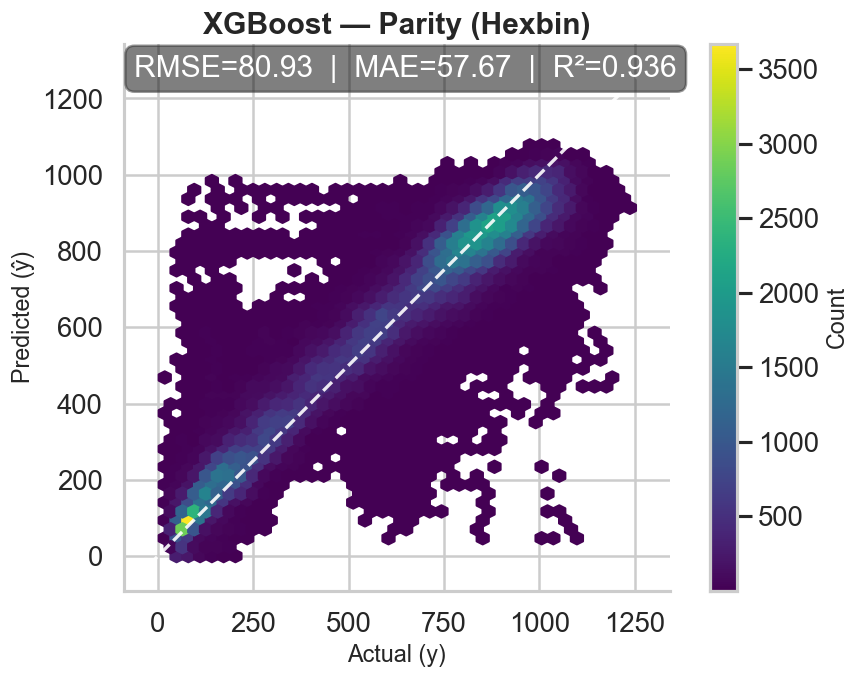

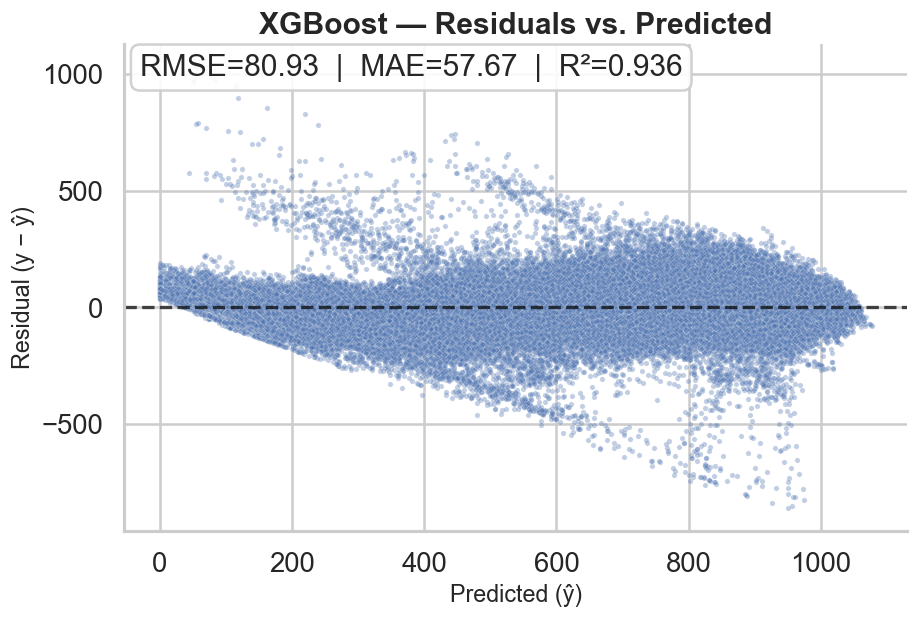

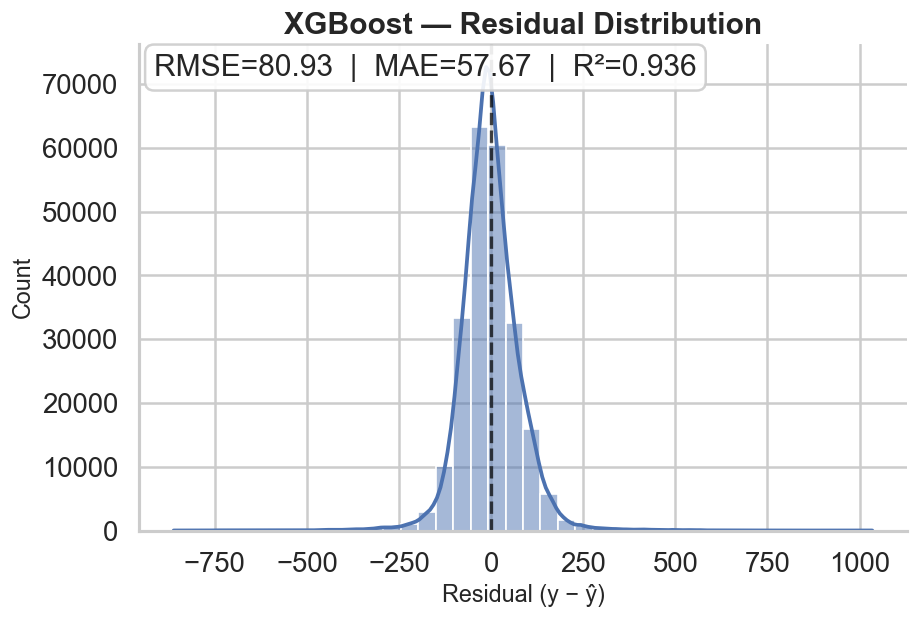

/var/folders/ww/hnj0z7l577b2_jzdg6515pfm0000gn/T/ipykernel_57667/244022642.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby("Decile").apply(
/var/folders/ww/hnj0z7l577b2_jzdg6515pfm0000gn/T/ipykernel_57667/244022642.py:114: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = df.groupby("Decile").apply(


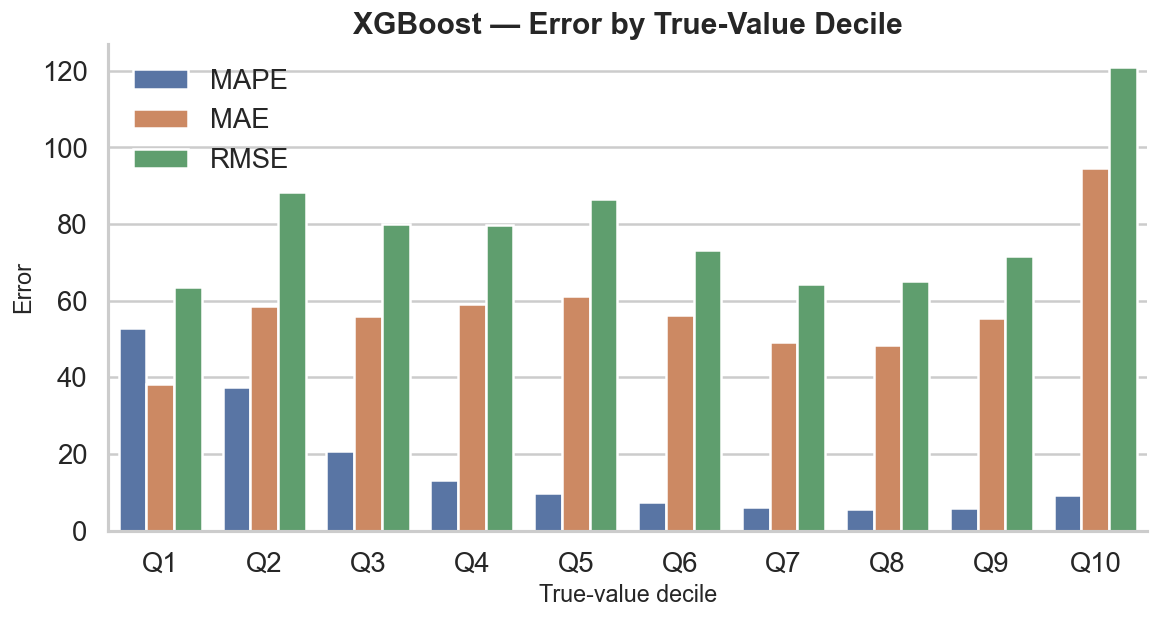

In [108]:
# You already have: y_true, y_pred_xgb
y = y_true
yp = y_pred_xgb

plot_parity_scatter(y, yp, title="XGBoost — Predicted vs. Actual", fname="ppt_parity_scatter.png")
# If your data is very dense, add hexbin too:
plot_parity_hexbin(y, yp, title="XGBoost — Parity (Hexbin)", fname="ppt_parity_hexbin.png")

plot_residuals_vs_pred(y, yp, title="XGBoost — Residuals vs. Predicted", fname="ppt_residuals_vs_pred.png")
plot_residual_dist(y, yp, title="XGBoost — Residual Distribution", fname="ppt_residual_dist.png")
plot_error_by_true_decile(y, yp, q=10, which=("MAPE","MAE","RMSE"),
                          title="XGBoost — Error by True-Value Decile",
                          fname="ppt_error_by_decile.png")
